In [1]:
import torch
import numpy as np
from dist_ae import SetAutoencoderGNN, SetAutoencoderTx, train_w_stop
from distns import distns
from tqdm.notebook import tqdm

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

distn_name = 'poisson'
generate_params = distns[distn_name]['generate_params']
sample_distn = distns[distn_name]['sample']
fr_dist = distns[distn_name]['fr_dist']

In [2]:
d = {'Set size' : [],
     'N sets' : [],
     'Architecture' : [],
     'Param. MSE' : []}


set_sizes = np.logspace(0, 3, 4, dtype=int)
n_sets = np.logspace(2, 4, 4, dtype=int)
n_features = 2

for set_size in tqdm(set_sizes, desc='set sizes', leave=True):
    for set_number in tqdm(n_sets, desc='set_number', leave=False):
        
        params_train = generate_params(set_number, n_features)
        params_val = generate_params(set_number//2, n_features)
        params_test = generate_params(1000, n_features)

        x_train = sample_distn(*params_train, set_number, set_size, n_features)
        x_val = sample_distn(*params_val, set_number//2, set_size, n_features)
        x_test = sample_distn(*params_test, 1000, set_size, n_features)

        train_loader = torch.utils.data.DataLoader(torch.from_numpy(x_train).float(), batch_size=32, shuffle=True)
        val_loader = torch.utils.data.DataLoader(torch.from_numpy(x_train).float(), batch_size=32, shuffle=False)

        dist_ae = SetAutoencoderGNN(n_features, 16, 64, set_size)
        optimizer = torch.optim.Adam(dist_ae.parameters(), lr=5e-4)

        dist_ae = train_w_stop(dist_ae, optimizer, 
                            train_loader, val_loader,
                            max_epochs = 300, device='cuda',
                            verbose=False)
        
        with torch.no_grad():
            z, rec = dist_ae(torch.from_numpy(x_test).float().cuda())

        mse = ((rec.mean(axis=1).cpu() - params_test[0])**2).mean().item()

        d['Set size'].append(set_size)
        d['N sets'].append(set_number)
        d['Architecture'].append('DistAE-GNN')
        d['Param. MSE'].append(mse)

        dist_ae = SetAutoencoderTx(n_features, 16, 64, set_size)
        optimizer = torch.optim.Adam(dist_ae.parameters(), lr=5e-4)

        dist_ae = train_w_stop(dist_ae, optimizer, 
                            train_loader, val_loader,
                            max_epochs = 300, device='cuda',
                            verbose=False)
        
        with torch.no_grad():
            z, rec = dist_ae(torch.from_numpy(x_test).float().cuda())

        mse = ((rec.mean(axis=1).cpu() - params_test[0])**2).mean().item()

        d['Set size'].append(set_size)
        d['N sets'].append(set_number)
        d['Architecture'].append('DistAE-Attn')
        d['Param. MSE'].append(mse)

set sizes:   0%|          | 0/4 [00:00<?, ?it/s]

set_number:   0%|          | 0/4 [00:00<?, ?it/s]

set_number:   0%|          | 0/4 [00:00<?, ?it/s]

set_number:   0%|          | 0/4 [00:00<?, ?it/s]

set_number:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
res_df = pd.DataFrame(d)
res_df

,Set size,N sets,Architecture,Param. MSE
0,1,100,DistAE-GNN,3338.571871
1,1,100,DistAE-Attn,3024.253341
2,1,464,DistAE-GNN,2240.066497
3,1,464,DistAE-Attn,2784.302772
4,1,2154,DistAE-GNN,2284.734506
5,1,2154,DistAE-Attn,3058.152824
6,1,10000,DistAE-GNN,2997.974271
7,1,10000,DistAE-Attn,3291.632416
8,10,100,DistAE-GNN,624.892746
9,10,100,DistAE-Attn,2726.739785


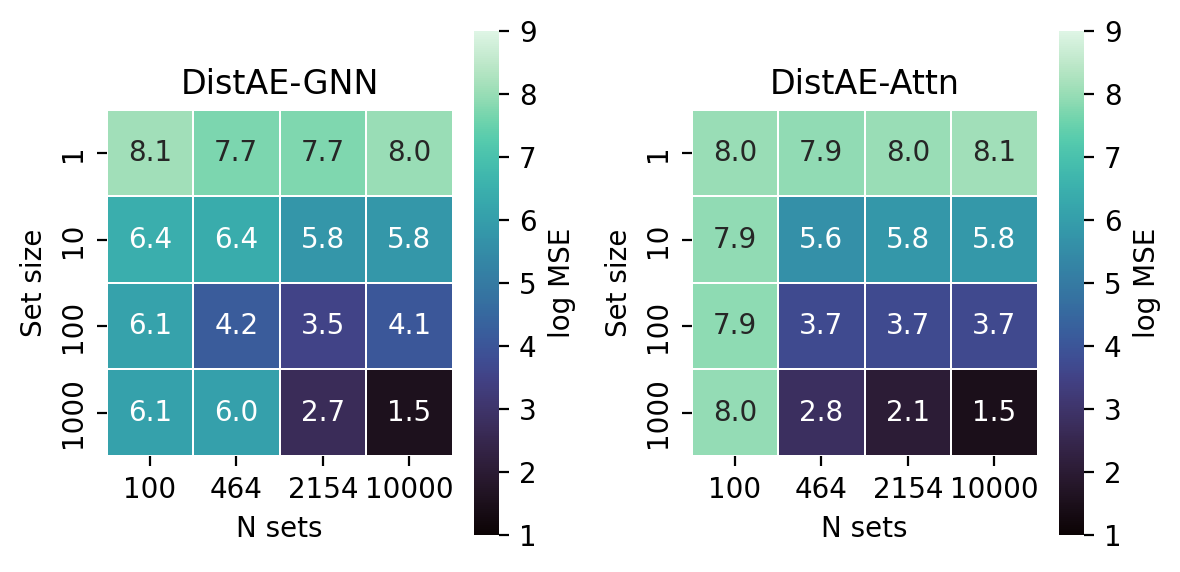

In [13]:
res_df['log_MSE'] = np.log(res_df['Param. MSE'])
archs = res_df['Architecture'].unique()

fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=200)
for ax, arch in zip(axes, archs):
    pivot = res_df[res_df['Architecture'] == arch].pivot_table(index='Set size', 
                                                               columns='N sets', 
                                                               values='log_MSE')
    sns.heatmap(pivot, ax=ax, cmap='mako', annot=True, fmt='.1f',
                square=True, cbar_kws={'label': 'log MSE'}, lw=0.1,
                vmin=1, vmax=9,)
    ax.set_title(arch)

plt.tight_layout()
plt.show()

In [5]:
res_df.to_csv('numerical_results/convergence_2D_pois.csv')